<a href="https://colab.research.google.com/github/MinyoungHer/Pytorch-study/blob/main/Pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN model with pytorch

## 0. pytorch에서의 컴퓨터 비전 라이브러리

* `torchvision`: pytorch에서 컴퓨터 비전 기본 라이브러리에 해당된다.
* `torchvision.datasets`: 데이터 셋과 데이터를 불러들이는 함수이다.
* `torchvision.transforms` : ML모델에 적합하도록 이미지 데이터를 조작할 수 있는 함수이다.
* `torch.utils.data.Dataset`: 기본 데이터셋 클래스를 불러올 수 있다.
*`torch.utils.data.DataLoader`: 반복가능한 데이터셋을 불러들이는 함수이다.

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


## 1. 데이터 셋 불러오기
Pytorch에서 FashioMNIST 데이터를 불러온다.


In [3]:
train_data=datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None

)

100%|██████████| 26421880/26421880 [00:01<00:00, 18290631.03it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 345129.60it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6024153.63it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6699434.38it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
# FashionMNIST데이터의 레이블은 다음과 같다.
class_names_idx=train_data.class_to_idx
class_names_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
# 레이블도 class_names로 저장하였다.
class_names=train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 1.2 데이터 시각화

FashionMNIST 데이터에 대한 간단한 시각화를 해본다.

Text(0.5, 1.0, 'Pullover')

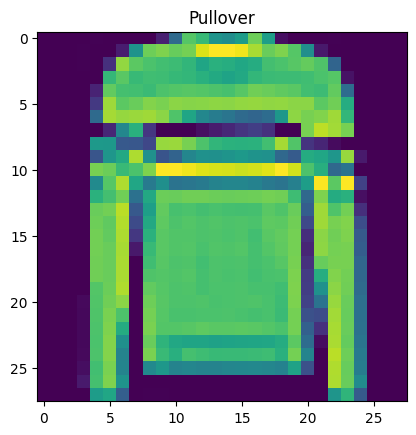

In [7]:
# 사용할 데이터는 다음과 같이 패션 그림에 관한 데이터이다.
import matplotlib.pyplot as plt
image, label=train_data[5]

plt.imshow(image.squeeze())
plt.title(class_names[label])

46666
3667
59785
3140
13885
19441
21693
27669
58380
4333
12194
3151
45859
43892
5165
18296


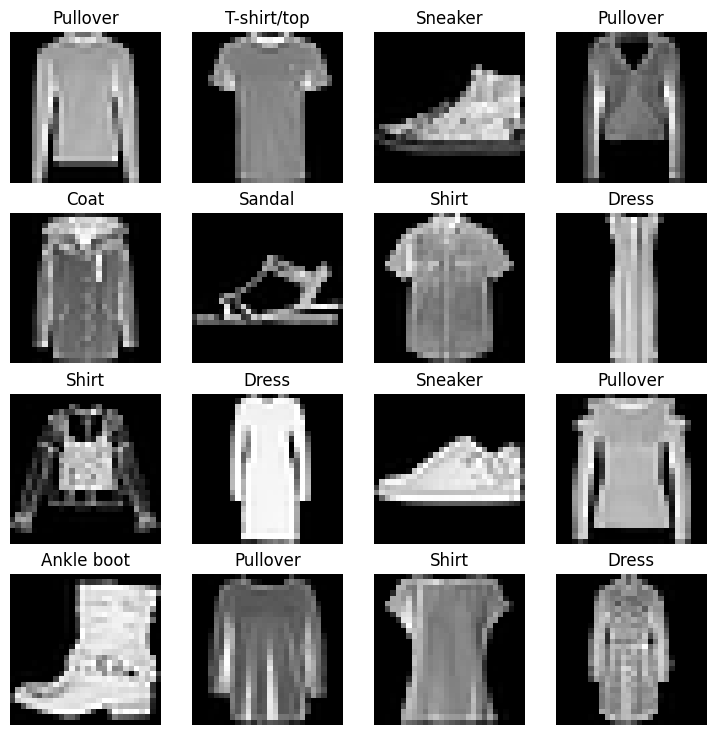

In [8]:
fig=plt.figure(figsize=(9,9))
rows, cols=4,4
for i in range(1, rows*cols+1):
  random_idx=torch.randint(0, len(train_data), size=[1]).item()
  print(random_idx)
  img, label=train_data[random_idx]
  plt.subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## 2. Dataloader 불러오기
* 반복가능한 형태의 Dataloader로 dataset을 바꾼다.
* 이는 데이터를 batch의 크기만큼 나누어서 업데이트하기 위한 과정이며 계산의 효율성 측면에서 장점이 있다.


In [9]:
from torch.utils.data import DataLoader

Batch_size=32

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=Batch_size,
                            shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                           batch_size=Batch_size,
                           shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc920303280>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc922841930>)

In [10]:
# training dataloader에 무엇이 있는지 확인한다.
train_features_batch, train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 3. CNN 모델 생성
* CNN은 시각적인 자료에서 패턴을 찾는데 유용하다.

다음은 CNN model을 위한 class를 생성하는 과정이다.

In [11]:
class CNNMODEL(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )



  def forward(self, x):
    x=self.conv_block1(x)
    #print(x.shape)
    x=self.conv_block2(x)
    #print(x.shape)
    x=self.classifier(x)
    #print(x.shape)
    return x


In [12]:
# 이를 model_CNN이라는 이름으로 모델을 설정하였다.
model_CNN=CNNMODEL(input_shape=1,
                   hidden_units=10,
                   output_shape=len(class_names))
model_CNN

CNNMODEL(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 3.1 손실함수와 최적화

모델을 설정하였으니 이제 학습을 위해서 손실함수와 최적화방법을 설정해주어야 한다.

In [13]:
#손실함수는 다중분류이므로 crossentropy를 사용한다.
loss_fn=nn.CrossEntropyLoss()
#최적화는 stochastic gradient descent 방법을 사용하였다.
optimizer=torch.optim.SGD(params=model_CNN.parameters(), lr=0.1)

### 3.2 정확도 함수 만들기
모델의 정확도 파악을 하기 위해 관련 함수를 생성한다.

In [14]:
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

### 3.3 학습과 테스트를 위한 함수 설정
모델 학습을 위한 함수를 따로 생성하고자 한다.

In [15]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
  train_loss, train_acc=0,0
  model.train()

  for batch, (X,y) in enumerate(data_loader):
    y_pred=model(X)

    loss=loss_fn(y_pred, y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y,
                           y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  train_loss/=len(data_loader)
  train_acc/=len(data_loader)

  print(f"train loss: {train_loss: .5f} | train acc: {train_acc: .2f}%")



In [16]:
def test_step(model:torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn):

  test_loss, test_acc=0,0


  model.eval()


  with torch.inference_mode():
    for X, y in data_loader:
      test_pred=model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                          y_pred=test_pred.argmax(dim=1))


    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | test acc: {test_acc: .2f}% \n")



In [17]:
# 함수 생성 완료후 이제 모델을 학습시킨다.

epochs=3
for epoch in range(epochs):
  train_step(model=model_CNN,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)
  test_step(model=model_CNN,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)




train loss:  0.57965 | train acc:  78.63%
Test loss: 0.37629 | test acc:  86.62% 

train loss:  0.34828 | train acc:  87.36%
Test loss: 0.35307 | test acc:  87.55% 

train loss:  0.31325 | train acc:  88.63%
Test loss: 0.32074 | test acc:  88.51% 



모델 결과를 보면 알 수 있듯, 반복 학습을 할 수록 손실이 줄어들면서 정확도가 올라간 것을 확인할 수 있다.


최종 결과로 모델의 정확도는 87%의 성능을 보여주었다.

### 3.4 CNN 모델 예측
* 먼저 우리가 설정한 모델은 로짓 값을 뱉어내므로 이를 확률로 바꿔주는 함수를 생성한다.


In [26]:
def make_prediction(model: torch.nn.Module,
                    data: list):
  pred_probs=[]
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample=torch.unsqueeze(sample, dim=0)
      pred_logit=model(sample)
      pred_prob=torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob)

  return torch.stack(pred_probs)

* 그리고 test data에서 random으로 sample을 뽑아낸 후 그 데이터를 가지고 예측을 시도해본다.

In [27]:
import random
test_sample=[]
test_lables=[]
for sample, lable in random.sample(list(test_data), k=9):
  test_sample.append(sample)
  test_lables.append(lable)

test_sample[0].shape


torch.Size([1, 28, 28])

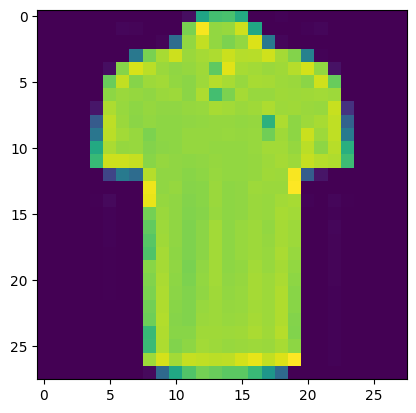

In [28]:
plt.imshow(test_sample[0].squeeze())

In [30]:
pred_probs= make_prediction(model=model_CNN,
                           data=test_sample)
pred_probs[0]

tensor([4.0425e-01, 1.3536e-06, 3.7311e-05, 3.7467e-03, 6.4340e-03, 3.7794e-07,
        5.8529e-01, 3.1934e-06, 2.3505e-04, 1.1918e-06])

모델에 데이터를 넣어본 결과 확률값이 나오는 것을 알 수 있다.

해당 확률을 가장 크게 가지고 있는 레이블을 이미지별로 뽑아낸다.

In [32]:
pred_class=pred_probs.argmax(dim=1)
pred_class

tensor([6, 4, 4, 8, 5, 6, 5, 8, 6])

이를 우리가 넣었던 이미지 데이터의 레이블과 비교해본다.

In [35]:
test_lables

[0, 4, 4, 8, 5, 6, 5, 8, 6]

하나의 데이터 말고는 모두 정확하게 예측한 것을 알 수 있다.

그림으로 나타내면 다음과 같이 나타난다.

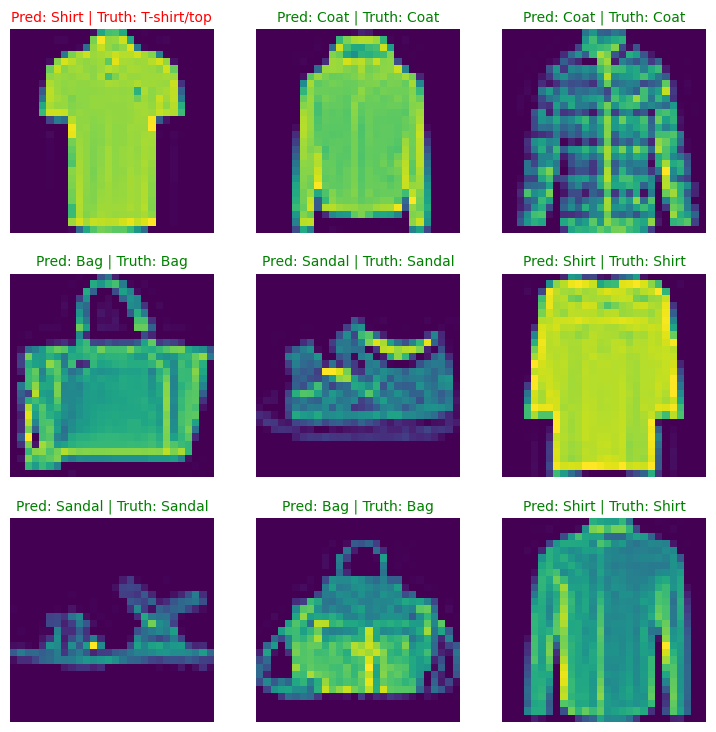

In [38]:
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i ,sample in enumerate(test_sample):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze())
  pred_label=class_names[pred_class[i]]
  truth_label=class_names[test_lables[i]]
  title_text=f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label==truth_label:
    plt.title(title_text, fontsize=10, c="g")

  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)


앞서 살펴보았던 것처럼 첫번째 데이터를 제외하고는 모두 예측이 잘 되었다는 것을 알 수 있다.

## 4. Confusion matrix

* `torchmetrics.ConfusionMatrix`으로 confusion matrix 생성이 가능하다.

* `mlxtend.plotting.plot_confusion_matrix()`으로 confusion matrix를 그릴 수 있다.

In [41]:
y_preds=[]
model_CNN.eval()
with torch.inference_mode():
  for X,y in test_dataloader:
    y_logit=model_CNN(X)
    y_pred=torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred)

  print(y_preds)
  y_pred_tensor=torch.cat(y_preds)
  y_pred_tensor[:3]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 3, 2, 6, 8, 0, 2, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8]), tensor([3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 9, 6, 7, 2, 3, 4, 6, 4, 4, 5, 8, 2, 2,
        8, 4, 8, 0, 7, 7, 8, 5]), tensor([1, 1, 3, 3, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 3, 8, 5, 9, 5, 0, 3, 2,
        0, 2, 5, 3, 6, 7, 1, 6]), tensor([6, 1, 6, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 2]), tensor([1, 5, 4, 1, 9, 1, 8, 6, 6, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 3, 2, 2, 2, 4,
        1, 4, 5, 6, 4, 7, 9, 3]), tensor([8, 2, 3, 8, 0, 9, 4, 8, 8, 2, 6, 5, 4, 1, 2, 1, 3, 0, 8, 1, 0, 9, 3, 6,
        7, 9, 8, 4, 4, 7, 1, 2]), tensor([3, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 6, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        3, 6, 7, 2, 8, 5, 6, 0]), tensor([7, 7, 6, 6, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 3, 2, 5, 6, 9, 2, 2, 8, 6, 4,
        6, 2, 9, 7, 3, 5, 5, 4]), tensor([8, 5, 2, 3, 0, 4, 8, 6, 0, 6, 3, 8, 9, 6, 1, 3, 6, 2, 3, 0, 8, 3, 7, 4,
       

In [45]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.1 MB/s eta 0:00:00
mlxtend version: 0.14.0


In [46]:
import mlxtend

In [47]:
len(y_pred_tensor)

10000

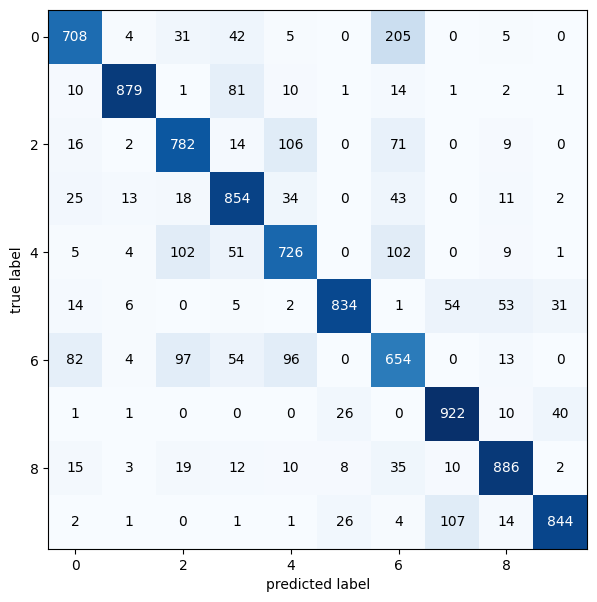

In [52]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat=ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor=confmat(preds=y_pred_tensor,
                       target=test_data.targets)

fig, ex=plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),

    figsize=(10,7)
)


Confusion matrix를 살펴보아도 알 수 있듯, 대부분의 이미지 데이터를 잘 학습했다는 것을 알 수 있다.